# Advanced Lane Finding

In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Camera Calibration

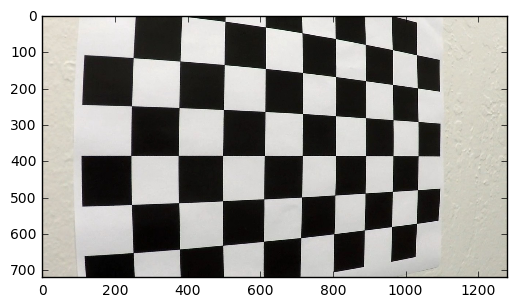

In [2]:
list_images = glob.glob('camera_cal/*')
img_chess = mpimg.imread(list_images[12])
plt.imshow(img_chess)

In [3]:
obj_points = []
img_points = []

nx = 9
ny = 6
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)
for im_path in list_images:
    img = mpimg.imread(im_path)
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    if ret:
        img_points.append(corners)
        obj_points.append(objp)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)


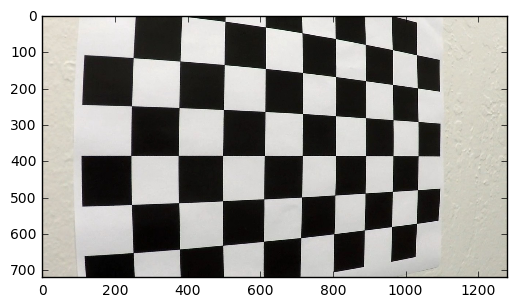

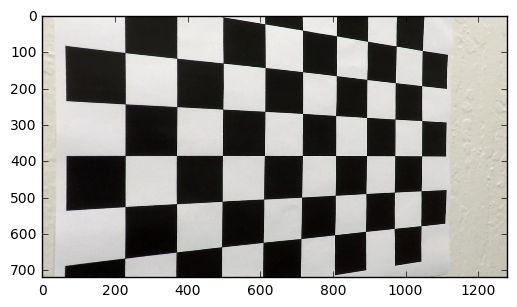

In [4]:
undist = cv2.undistort(img_chess, mtx, dist, None, mtx)
plt.figure()
plt.imshow(img_chess)
plt.figure()
plt.imshow(undist)

## Binarization of images using gradients and color transformation

In [5]:
# functions to get a good mask for an image
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)

    scaled_sobel = np.uint8(255*(abs_sobel/np.max(abs_sobel)))

    binary_output = scaled_sobel > thresh[0]
    binary_output = binary_output*(scaled_sobel < thresh[1])
    return binary_output


def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobel = np.sqrt(np.power(sobelx, 2) + np.power(sobely, 2))
    scaled_sobel = np.uint8(255*(abs_sobel/np.max(abs_sobel)))
    binary_output = scaled_sobel > mag_thresh[0]
    binary_output = binary_output*(scaled_sobel < mag_thresh[1])
    return binary_output


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    angle_sobel = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = angle_sobel > thresh[0]
    binary_output = binary_output*(angle_sobel < thresh[1])
    return binary_output


def filter_l_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_ch = hls[:,:,1]
    binary_output = np.zeros_like(l_ch)
    binary_output[(l_ch > thresh[0]) & (l_ch <= thresh[1])] = 1
    return binary_output


def filter_s_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_ch = hls[:,:,2]
    binary_output = np.zeros_like(s_ch)
    binary_output[(s_ch > thresh[0]) & (s_ch <= thresh[1])] = 1
    return binary_output

In [6]:
road_list_images = glob.glob('test_images/*')
print(road_list_images)
img_road = mpimg.imread(road_list_images[3])

['test_images/test4.jpg', 'test_images/test3.jpg', 'test_images/test2.jpg', 'test_images/test5.jpg', 'test_images/straight_lines1.jpg', 'test_images/test1.jpg', 'test_images/test6.jpg', 'test_images/straight_lines2.jpg']


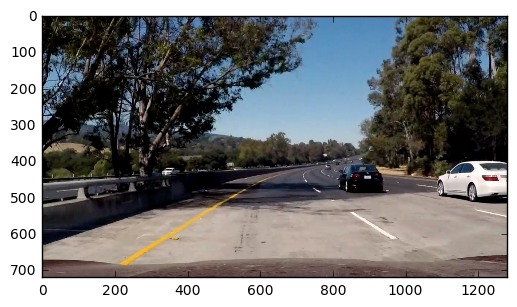

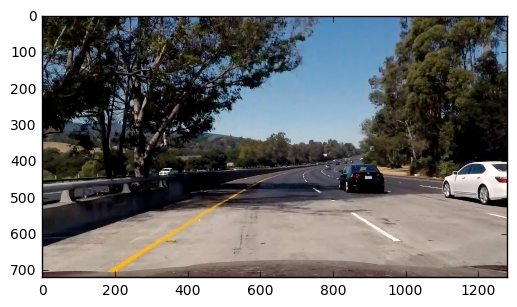

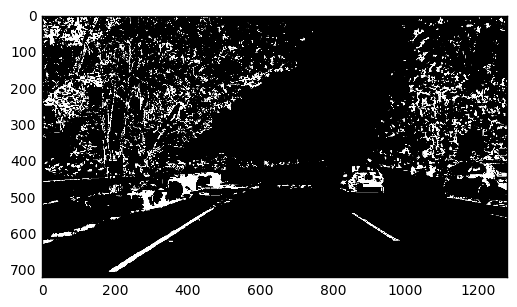

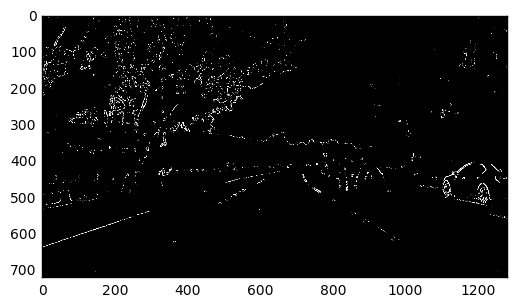

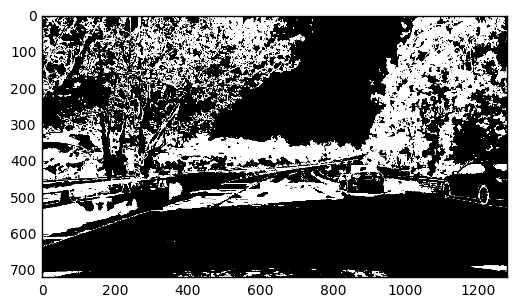

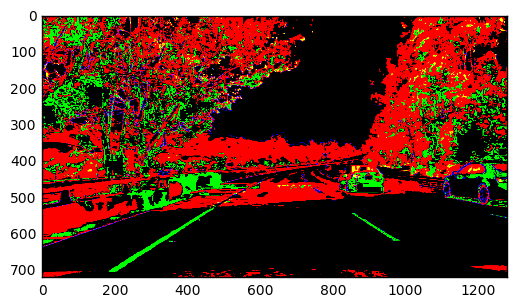

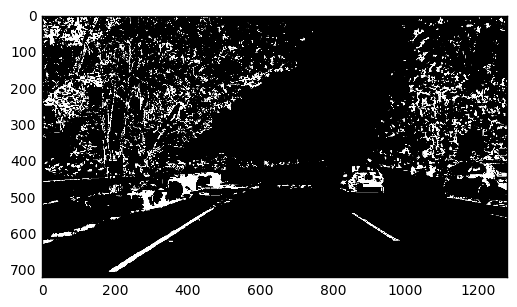

In [7]:
# Apply each of the thresholding functions
ksize=3

img_road_undist = cv2.undistort(img_road, mtx, dist, None, mtx)
gradx = abs_sobel_thresh(img_road_undist, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(img_road_undist, orient='y', sobel_kernel=ksize, thresh=(30, 120))
mag_binary = mag_thresh(img_road_undist, sobel_kernel=ksize, mag_thresh=(70, 230))
dir_binary = dir_threshold(img_road_undist, sobel_kernel=ksize, thresh=(0.1, 1.4))
l_binary = filter_l_select(img_road_undist, thresh=(20,80))
s_binary = filter_s_select(img_road_undist, thresh=(150,255))


combined = np.zeros_like(dir_binary)
#combined[((mag_binary == 1)&(dir_binary==1)) | (s_binary == 1)] = 1
combined[(s_binary == 1)] = 1
combined_gray = np.uint8(255*combined)
combined_color = cv2.cvtColor(combined_gray, cv2.COLOR_GRAY2RGB)

rc = np.uint8(np.zeros_like(s_binary))
gc = np.uint8(np.zeros_like(s_binary))
bc = np.uint8(np.zeros_like(s_binary))
bc[(mag_binary == 1)&(dir_binary==1)] = 1
gc[s_binary==1] = 1
rc[l_binary==1] = 1

color_binary = np.dstack((255*rc, 255*gc, 255*bc))

plt.figure()
plt.imshow(img_road)
plt.figure()
plt.imshow(img_road_undist)
plt.figure()
plt.imshow(gc,cmap='gray')
plt.figure()
plt.imshow(bc,cmap='gray')
plt.figure()
plt.imshow(rc,cmap='gray')
plt.figure()
plt.imshow(color_binary)
plt.figure()
plt.imshow(combined,cmap='gray')

## Perspective transform

* select four points (vertices) to make a perspective transform and get the "bird-eye view"

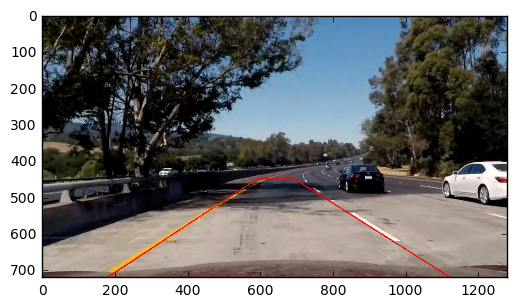

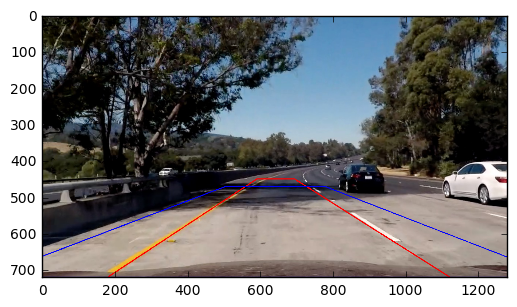

In [8]:
# set and draw trapezoidal section of the road
vertices = np.array([[(180, img_road_undist.shape[0]),
                      (590, 450),
                      (693, 450),
                      (1120, img_road_undist.shape[0])]], dtype=np.int32)
img_example_section = img_road_undist.copy()
section_image_red = cv2.drawContours(img_example_section, vertices, 0, (255,0,0), 2)
section_image_red_copy = section_image_red.copy()

plt.figure()
plt.imshow(section_image_red)

# source points for transformation
blue_srcp = srcp = np.array([[(505, 470),
                              (775, 470),
                              (1420, img_road_undist.shape[0]),
                              (-150, img_road_undist.shape[0])]], dtype=np.int32)

# draw source points
section_image_red_blue = cv2.drawContours(section_image_red_copy, blue_srcp, 0, (0,0,255), 2)
plt.figure()
plt.imshow(section_image_red_blue)

* perform perspective transformation using opencv

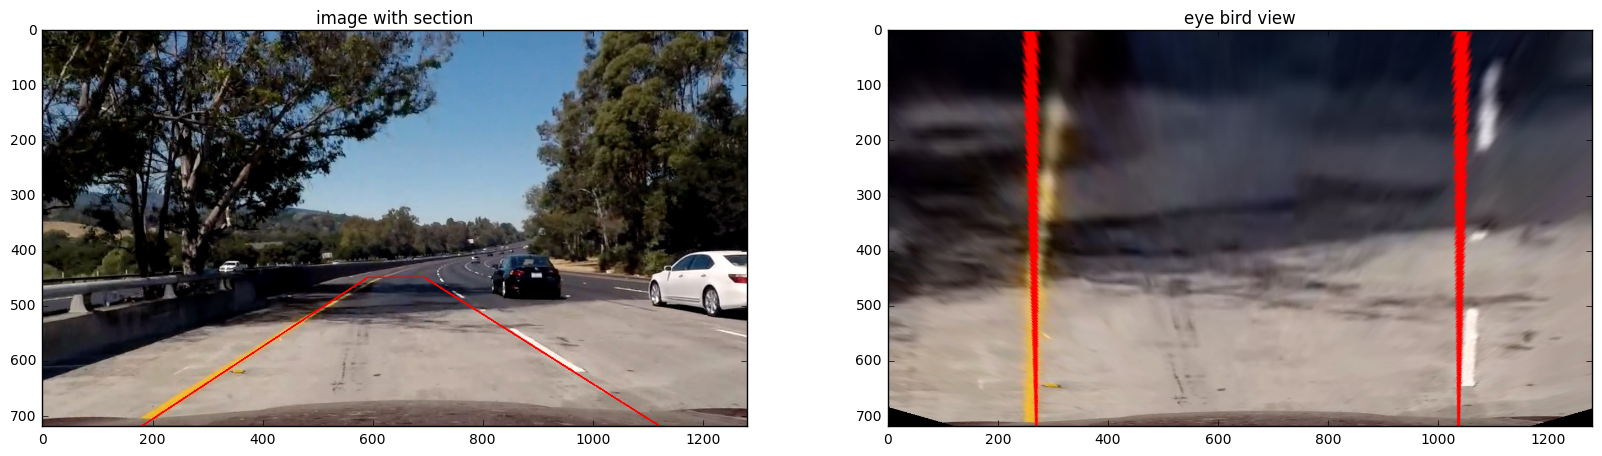

In [9]:
img_size=(img_road_undist.shape[1], img_road_undist.shape[0])
dstp = np.float32([[0, 0],
                    [img_size[0], 0],
                    [img_size[0], img_size[1]],
                    [0, img_size[1]]])
M = cv2.getPerspectiveTransform(np.float32(blue_srcp), dstp)
Minv = cv2.getPerspectiveTransform(dstp, np.float32(blue_srcp))

warped = cv2.warpPerspective(section_image_red, M, img_size)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('image with section')
ax1.imshow(section_image_red)

ax2.set_title('eye bird view')
ax2.imshow(warped, cmap='gray')

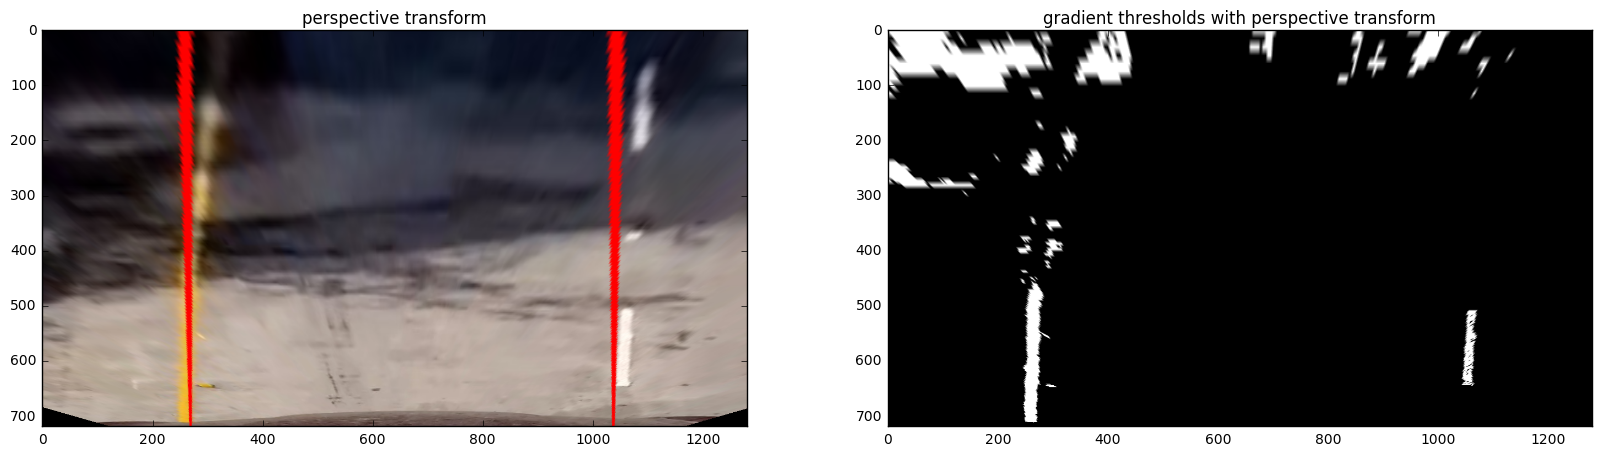

In [10]:
warped_binarized = cv2.warpPerspective(combined_gray, M, img_size)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('perspective transform')
ax1.imshow(warped)

ax2.set_title('gradient thresholds with perspective transform')
ax2.imshow(warped_binarized, cmap='gray')

## Finding Lanes

convolution approach

In [ ]:
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

'''from udacity course'''

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center, r_center))

    return window_centroids

warped = warped_binarized.copy()
window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
    # if no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.figure()
plt.imshow(output)
plt.title('window fitting results')
plt.show()

Histogram approach

In [11]:
'''from udacity course'''
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
binary_warped = warped_binarized.copy()

histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

719.0

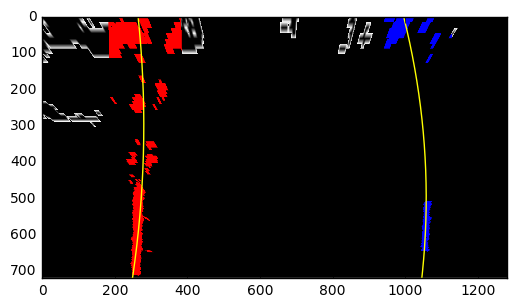

In [19]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
ploty[-1]

(720, 0)

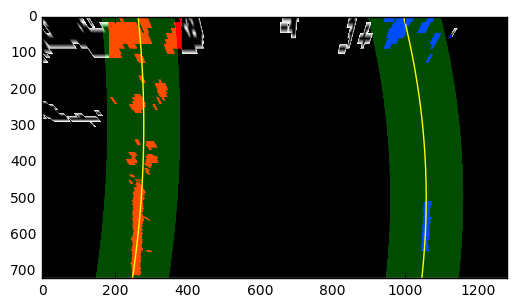

In [13]:
binary_warped = warped_binarized.copy()
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#-----------------------------------------------------------
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

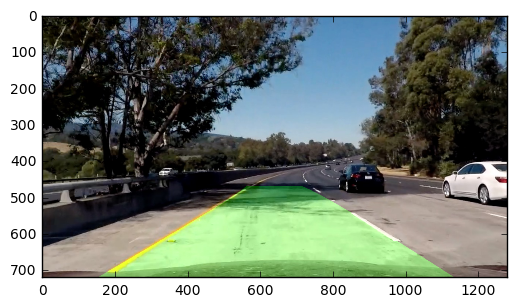

In [14]:
warped = warped_binarized.copy()

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img_road_undist.shape[1], img_road_undist.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img_road_undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

## Estimate curvature

In [15]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

2936.91498927 2044.70061997


In [17]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

934.296493282 m 659.814181361 m


## how far is the car of the road

In [20]:
# how far is the car from the middle of the road
x1_meters = left_fitx[-1]*xm_per_pix
x2_meters = right_fitx[-1]*xm_per_pix
my_x = (warped_binarized.shape[1]/2)*xm_per_pix
x_middle_meters = (x1_meters + x2_meters)/2
print(my_x,x_middle_meters)

3.382857142857143 3.41883102837


## Visualize results in video

In [22]:
# Define a class to receive the characteristics of each line detection
from IPython.display import HTML
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [40]:
def process_frame(input_image):
    # pipeline here
    
    # remove distorsion from image
    img_road_undist = cv2.undistort(input_image, mtx, dist, None, mtx)
    
    # threshold image
    s_binary = filter_s_select(img_road_undist, thresh=(150,255))
    combined = np.zeros_like(s_binary)
    combined[(s_binary == 1)] = 1
    combined_gray = np.uint8(255*combined)

    # perspective transformation
    warped_binarized = cv2.warpPerspective(combined_gray, M, (img_road_undist.shape[1], img_road_undist.shape[0]))
    
    binary_warped = warped_binarized.copy()

    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    color_warp[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    color_warp[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_road_undist.shape[1], img_road_undist.shape[0]))
    # Combine the result with the original image
    output_image = cv2.addWeighted(img_road_undist, 1, newwarp, 0.5, 0)
    return output_image

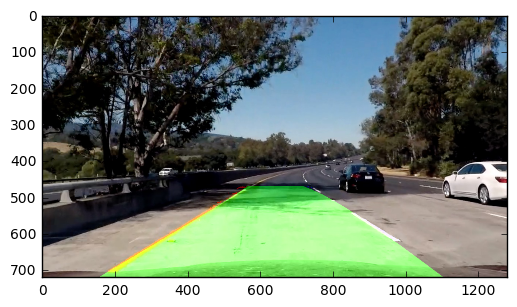

In [41]:
out = process_frame(img_road)
plt.figure()
plt.imshow(out)

In [24]:
new_clip_output = 'project_video.mp4'

HTML("""
<video width="640" height="300" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(new_clip_output))

In [ ]:
# Import everything needed to edit/save/watch video clips
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML

In [ ]:
#import imageio 
#imageio.plugins.ffmpeg.download()